In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
model_path = "/home/zhoujieli/Documents/protein_llm/protein_ring/esm2_t12_35M_UR50D-35M-feb24/checkpoint-3165"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [3]:
df = pd.read_csv("/media/zhoujieli/T5 EVO/multimer_esm_project/df_merged_train_test.csv")

In [4]:
test_sequences = df["sequence"][df["test"]==True].tolist()
test_labels = df["sym"][df["test"]==True].tolist()
test_inputs = tokenizer(test_sequences, return_tensors="pt", padding=True, truncation=True, max_length=1024)
test_dataset = Dataset.from_dict(test_inputs)
test_dataset = test_dataset.add_column("labels", test_labels)

In [5]:
test_inputs["input_ids"].shape

torch.Size([8439, 1024])

In [6]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
len(test_loader)

66

In [8]:
# Custom collate_fn to handle conversion from lists to tensors
def collate_fn(batch):
    # Convert list of dicts to dict of lists
    batch = {key: [d[key] for d in batch] for key in batch[0]}

    # Convert lists to tensors
    input_ids = torch.tensor(batch['input_ids'])
    attention_mask = torch.tensor(batch['attention_mask'])
    
    # Optionally handle labels if you have them
    if 'labels' in batch:
        labels = torch.tensor(batch['labels'])
        return input_ids, attention_mask, labels

    return input_ids, attention_mask

# Create DataLoader with custom collate_fn
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

In [14]:
from tqdm.auto import tqdm
import torch

# Assuming you have already set your model to evaluation mode using model.eval()

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Initialize a list to store the predictions
predictions = []

# Initialize a list to store the predicted class labels (if needed)
predicted_labels = []

# Using DataLoader, this loop should iterate over batches
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask = batch[:2]  # If you have labels, they would be in batch[2]
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        # Forward pass, get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply softmax to the logits to get probabilities
        scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Convert the probabilities to CPU and to a NumPy array
        predicted_probs = scores.cpu().numpy()

        # Extend the predictions list with the probabilities
        predictions.extend(predicted_probs)

        # Optionally, if you want to get the predicted class labels
        predicted_labels.extend(torch.argmax(scores, dim=-1).cpu().numpy())

# Debug: Check the total number of predictions
print(f"Total predictions: {len(predictions)}")

# Each element of predictions is now a list of probabilities for the three classes
# For example: [0.2, 0.3, 0.5] for a single data point

# Debug: Check if the number of predictions matches the expected number of data points
assert len(predictions) == len(test_loader.dataset), "Number of predictions does not match number of data points."

# predictions is now a list of lists, where each sublist contains the probabilities of the three classes

  0%|          | 0/132 [00:00<?, ?it/s]

Total predictions: 8439


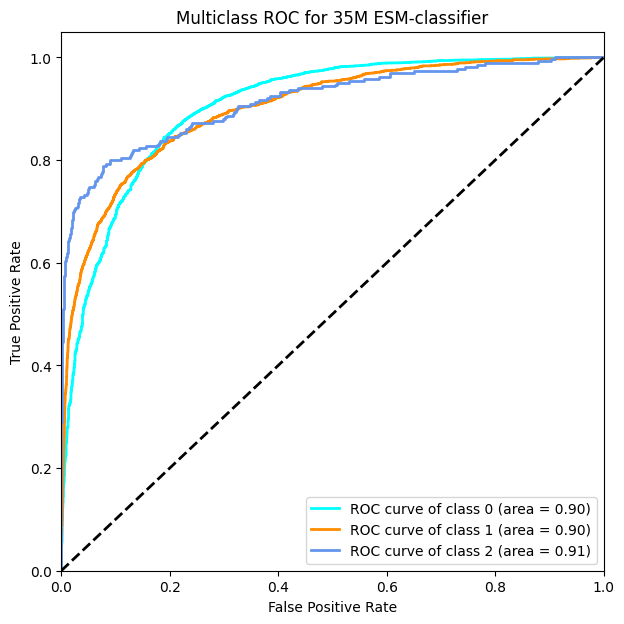

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
# Convert predictions to a NumPy array
predictions = np.array(predictions)
# Assuming test_labels are your true labels for the test set
# and predictions is an array with shape (n_samples, n_classes)
# where each element is the probability of that class.

# Binarize the labels for the multi-class problem
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_labels_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC for 35M ESM-classifier')
plt.legend(loc="lower right")
plt.show()

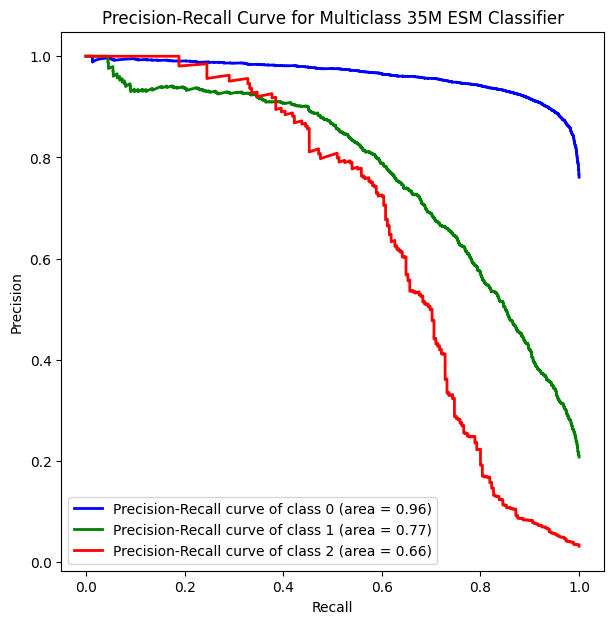

In [24]:
# Binarize the labels for the multi-class problem
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = test_labels_binarized.shape[1]

# Compute Precision-Recall and plot curve for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(test_labels_binarized[:, i], predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot all Precision-Recall curves
plt.figure(figsize=(7, 7))

colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass 35M ESM Classifier')
plt.legend(loc="lower left")
plt.show()

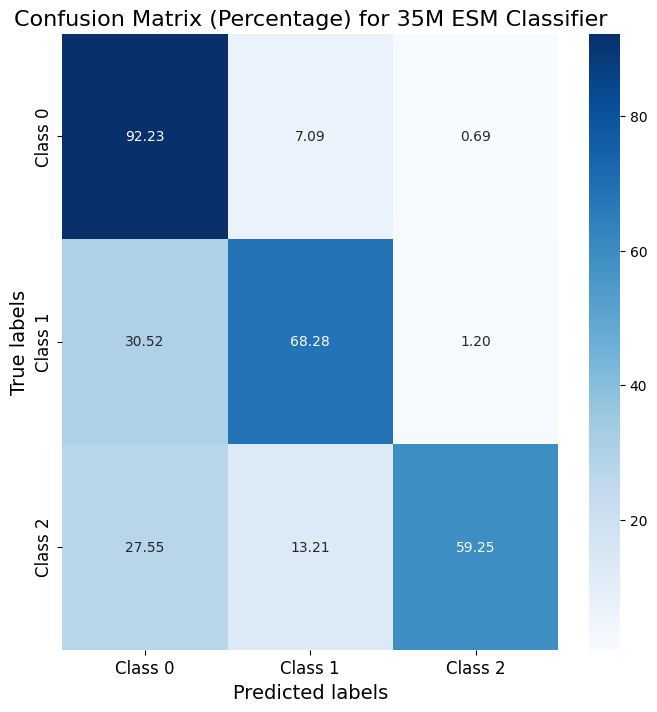

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions is an array with shape (n_samples, n_classes)
# and contains the predicted probabilities for each class
# Convert the predicted probabilities to binary predictions
# The predicted class is the one with the highest probability
binary_predictions = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)

# Normalize the confusion matrix by row (i.e., by the number of true labels in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert the numbers into percentages
cm_percentage = cm_normalized * 100

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', ax=ax, cmap=plt.cm.Blues, alpha=1, cbar=True)

# labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Confusion Matrix (Percentage) for 35M ESM Classifier', fontsize=16)
ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2'], fontsize=12)
ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2'], fontsize=12)
plt.show()